In [1]:
# Let's import the necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
from varname import nameof

import requests
from bs4 import BeautifulSoup
import html
import lxml

import sys, os

dir = os.path.dirname
sys.path.append(dir(os.getcwd()))

import src.utils.mining_data_tb as md
import src.utils.visualization_tb as vis
import src.utils.folder_tb as fo

import warnings
warnings.filterwarnings('ignore')

The purpose of my EDA is to find out whether a diet based on animal produts is efficient from a societal perspective.

This means, I'll do a cost-benefit analysis of the food animal sources and compare it to veggie alternatives.

For that purpose, I'll use the following data:
- Resources for food production (cost)
- Nutritional values of the food & recommended daily intake (benefit)

By measuring the relation between resources and nutritional values, we can determine which foods are more efficient.

# Basic exploration and cleaning

As mentioned before, we'll use three datasets:
- Resources: This is actually composed by several csv files that we will merge
- Nutritional values: It shows +60 nutrients (columns) for +7000 different foods (rows)
- Daily intakes: It is a CSV with the urls of the recommended daily intake according to gender and age. We will do some scrapping here to pull this data

## Resources

In [2]:
# Let's start by exploring the resources datasets

# 1) dataset with general info
path_ = fo.path_to_folder(2, "data")
resources_1 = pd.read_csv(path_ + "Food_production.csv")
resources_1.head()

,Food product,Land use change,Animal Feed,Farm,Processing,Transport,Packging,Retail,Total_emissions,Eutrophying emissions per 1000kcal (gPO₄eq per 1000kcal),...,Freshwater withdrawals per 100g protein (liters per 100g protein),Freshwater withdrawals per kilogram (liters per kilogram),Greenhouse gas emissions per 1000kcal (kgCO₂eq per 1000kcal),Greenhouse gas emissions per 100g protein (kgCO₂eq per 100g protein),Land use per 1000kcal (m² per 1000kcal),Land use per kilogram (m² per kilogram),Land use per 100g protein (m² per 100g protein),Scarcity-weighted water use per kilogram (liters per kilogram),Scarcity-weighted water use per 100g protein (liters per 100g protein),Scarcity-weighted water use per 1000kcal (liters per 1000 kilocalories)
0,Wheat & Rye (Bread),0.1,0.0,0.8,0.2,0.1,0.1,0.1,1.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Maize (Meal),0.3,0.0,0.5,0.1,0.1,0.1,0.0,1.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Barley (Beer),0.0,0.0,0.2,0.1,0.0,0.5,0.3,1.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Oatmeal,0.0,0.0,1.4,0.0,0.1,0.1,0.0,1.6,4.281357,...,371.076923,482.4,0.945482,1.907692,2.897446,7.6,5.846154,18786.2,14450.92308,7162.104461
4,Rice,0.0,0.0,3.6,0.1,0.1,0.1,0.1,4.0,9.514379,...,3166.760563,2248.4,1.207271,6.267606,0.759631,2.8,3.943662,49576.3,69825.77465,13449.891480


In [3]:
resources_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 23 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   Food product                                                             43 non-null     object 
 1   Land use change                                                          43 non-null     float64
 2   Animal Feed                                                              43 non-null     float64
 3   Farm                                                                     43 non-null     float64
 4   Processing                                                               43 non-null     float64
 5   Transport                                                                43 non-null     float64
 6   Packging                                                                 43 

Right now, we can already see several things:
- A tone of NaN values
- Many columns refering to emissions: from "Land use change" to "Retail", they all refer to emissions. As the columns "Total_emissions" is the sum of the previous ones, I'll keep just this one and drop the rest. 
- Additionally, I'm interested in the data of water and land use, as I've found other datasets that can fill some of the missing values.

In [4]:
# Let's have a look at the datasets with the missing information of water use and land use
# As I have three datasets for each (water/land use per kg of food, per 1000kcal and per 100g of protein), I'll just check one of each as examples

path_1 = fo.path_to_folder(2, "data/Resources_use")
water_1 = pd.read_csv(path_1 + "freshwater-withdrawals-per-kg.csv")
water_1.head()

,Entity,Code,Year,"Freshwater withdrawals per kilogram (Poore & Nemecek, 2018)"
0,Apples,NaN,2010,180.1
1,Bananas,NaN,2010,114.5
2,Barley,NaN,2010,17.1
3,Beef (beef herd),NaN,2010,1451.2
4,Beef (dairy herd),NaN,2010,2714.3


In [5]:
water_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 4 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   Entity                                                       43 non-null     object 
 1   Code                                                         0 non-null      float64
 2   Year                                                         43 non-null     int64  
 3   Freshwater withdrawals per kilogram (Poore & Nemecek, 2018)  43 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.5+ KB


In [6]:
# Let's do the same for land (just one example)

path_2 = fo.path_to_folder(2, "data/Resources_use")
land_1 = pd.read_csv(path_2 + "land-use-per-kg-poore.csv")
land_1.head()

,Entity,Code,Year,"Land use per kilogram (Poore & Nemecek, 2018)"
0,Apples,NaN,2010,0.63
1,Bananas,NaN,2010,1.93
2,Barley,NaN,2010,1.11
3,Beef (beef herd),NaN,2010,326.21
4,Beef (dairy herd),NaN,2010,43.24


In [7]:
land_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 4 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Entity                                         43 non-null     object 
 1   Code                                           0 non-null      float64
 2   Year                                           43 non-null     int64  
 3   Land use per kilogram (Poore & Nemecek, 2018)  43 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.5+ KB


Well, we can see here that in the land/water datasets, we actually have the info for the 43 foods analysed, whereas in the general ones we were missing some.

To conclude, for the cleaning part, I'd like to the following with these datasets:

1. Merge the general dataset with the water and land use ones, to fill in the missings

2. Drop the columns I don't need. I just want to keep "Total_emissions" and all the columns related to "land use" and "freshwater withdrawls"

3. Match the names differences: in the general dataset we have "Tofu" and in the others we have "Tofu (soybeans)". They refer to the same food but the naming is different. We'll have to deal with that

Luckily, we have already have functions to do al this. We'll do after finish the exploration part of the other two datasets.

## Nutritional values and recommended daily intake

In [8]:
# Let's start with the nutritional values dataset

path_3 = fo.path_to_folder(2, "data")
nutritional_values = pd.read_excel(path_3 + "2017-2018 FNDDS At A Glance - FNDDS Nutrient Values.xlsx")
nutritional_values.head()

,FNDDS Nutrient Values\n2017-2018 Food and Nutrient Database for Dietary Studies - At A Glance,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68
0,Food code,Main food description,WWEIA Category number,WWEIA Category description,Energy (kcal),Protein (g),Carbohydrate (g),"Sugars, total\n(g)","Fiber, total dietary (g)",Total Fat (g),...,20:1\n(g),22:1\n(g),18:2\n(g),18:3\n(g),18:4\n(g),20:4\n(g),20:5 n-3\n(g),22:5 n-3\n(g),22:6 n-3\n(g),Water\n(g)
1,11000000,"Milk, human",9602,Human milk,70,1.03,6.89,6.89,0,4.38,...,0.04,0,0.374,0.052,0,0.026,0,0,0,87.5
2,11100000,"Milk, NFS",1004,"Milk, reduced fat",51,3.34,4.87,4.89,0,1.99,...,0.002,0,0.069,0.007,0,0.003,0,0.001,0,89.04
3,11111000,"Milk, whole",1002,"Milk, whole",60,3.28,4.67,4.81,0,3.2,...,0.004,0,0.115,0.012,0,0.004,0.001,0.002,0,88.1
4,11111100,"Milk, low sodium, whole",1002,"Milk, whole",61,3.1,4.46,4.46,0,3.46,...,0,0,0.078,0.05,0,0,0,0,0,88.2


Well, first thing we notice is that fact that the header is incorrect. We will need to read the file from the second row.

In [9]:
# Let's read again the dataset starting by the second row

path_3 = fo.path_to_folder(2, "data")
nutritional_values = pd.read_excel(path_3 + "2017-2018 FNDDS At A Glance - FNDDS Nutrient Values.xlsx", skiprows = 1)
nutritional_values.head()

,Food code,Main food description,WWEIA Category number,WWEIA Category description,Energy (kcal),Protein (g),Carbohydrate (g),"Sugars, total\n(g)","Fiber, total dietary (g)",Total Fat (g),...,20:1\n(g),22:1\n(g),18:2\n(g),18:3\n(g),18:4\n(g),20:4\n(g),20:5 n-3\n(g),22:5 n-3\n(g),22:6 n-3\n(g),Water\n(g)
0,11000000,"Milk, human",9602,Human milk,70,1.03,6.89,6.89,0.0,4.38,...,0.040,0.0,0.374,0.052,0.0,0.026,0.000,0.000,0.0,87.50
1,11100000,"Milk, NFS",1004,"Milk, reduced fat",51,3.34,4.87,4.89,0.0,1.99,...,0.002,0.0,0.069,0.007,0.0,0.003,0.000,0.001,0.0,89.04
2,11111000,"Milk, whole",1002,"Milk, whole",60,3.28,4.67,4.81,0.0,3.20,...,0.004,0.0,0.115,0.012,0.0,0.004,0.001,0.002,0.0,88.10
3,11111100,"Milk, low sodium, whole",1002,"Milk, whole",61,3.10,4.46,4.46,0.0,3.46,...,0.000,0.0,0.078,0.050,0.0,0.000,0.000,0.000,0.0,88.20
4,11111150,"Milk, calcium fortified, whole",1002,"Milk, whole",60,3.28,4.67,4.81,0.0,3.20,...,0.004,0.0,0.115,0.012,0.0,0.004,0.001,0.002,0.0,88.10


In [10]:
# Now, this is more like it
# Let's continue the checking

nutritional_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7083 entries, 0 to 7082
Data columns (total 69 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Food code                               7083 non-null   int64  
 1   Main food description                   7083 non-null   object 
 2   WWEIA Category number                   7083 non-null   int64  
 3   WWEIA Category description              7083 non-null   object 
 4   Energy (kcal)                           7083 non-null   int64  
 5   Protein (g)                             7083 non-null   float64
 6   Carbohydrate (g)                        7083 non-null   float64
 7   Sugars, total
(g)                       7083 non-null   float64
 8   Fiber, total dietary (g)                7083 non-null   float64
 9   Total Fat (g)                           7083 non-null   float64
 10  Fatty acids, total saturated (g)        7083 non-null   floa

Several things to comment on:

1. We have no missing values -> Great!

2. Some columns have names with no meaning (for instance, 16:1). They are obviously coded

3. Some of the columns with the right names have some mistypings such as "\n" in the names

Before doing any cleaning of the column names, we need to know which nutrients we are interested in. Maybe we can spare some time there.

Let's do some more checking of this dataframe before moving on to the daily intakes one.

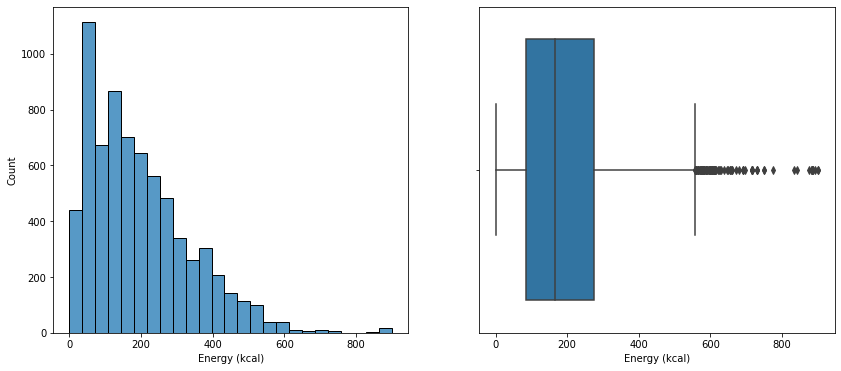

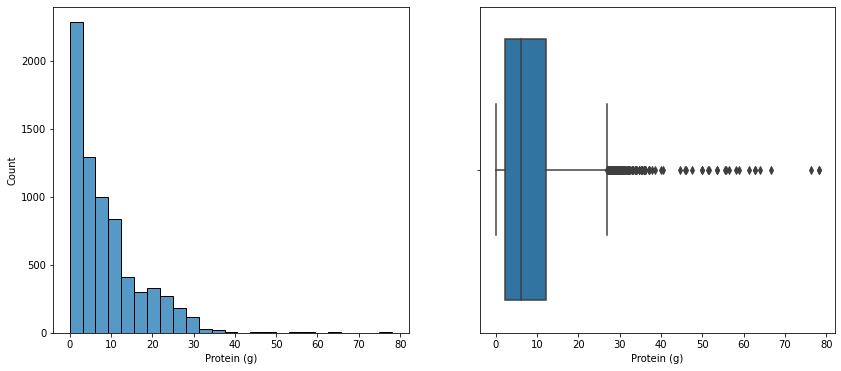

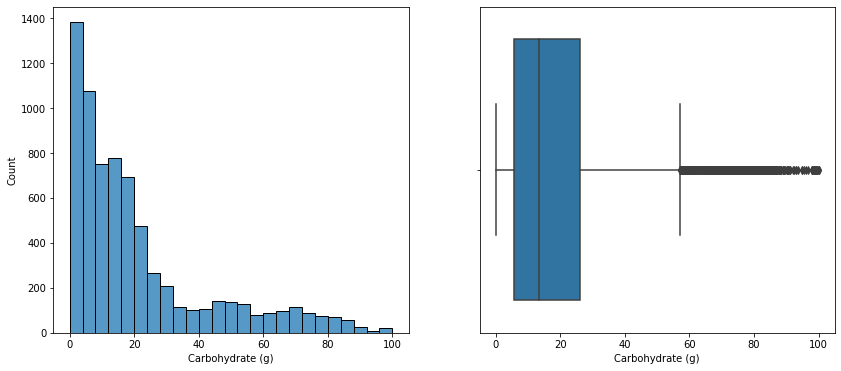

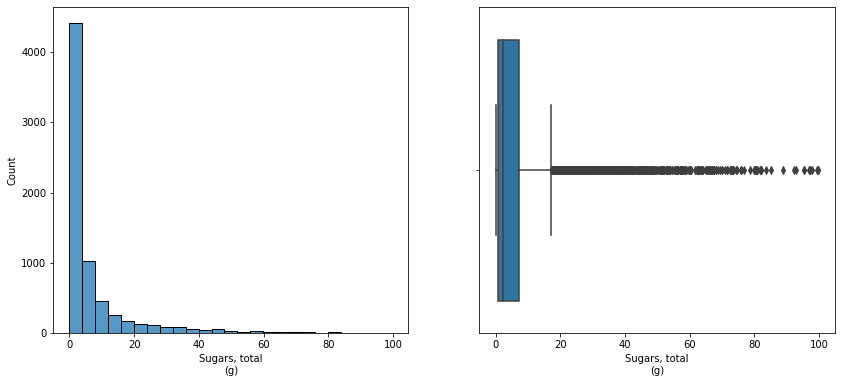

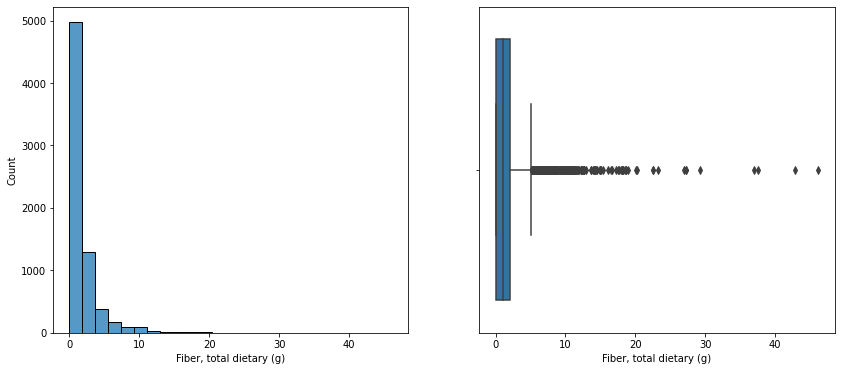

In [12]:
# Let's have a look at the distributions

# I will only plot a few of the columns for example purposes, as it takes a lot of memory, but I've already done it for all the columns.

vis.hist_and_box_plots(nutritional_values, 4, 9, 25)    # args : df, start_column, stop_column, n_of_bins
plt.show()

We can see here that we have some outliers in every nutrient (column). However, this is quite normal keeping in mind the type of data we are working with. Let's have a look at some of the protein outliers, just for fun.

In [15]:
nutritional_values[nutritional_values["Protein (g)"] > 30].sort_values(by = "Protein (g)", ascending = False).head(10)

,Food code,Main food description,WWEIA Category number,WWEIA Category description,Energy (kcal),Protein (g),Carbohydrate (g),"Sugars, total\n(g)","Fiber, total dietary (g)",Total Fat (g),...,20:1\n(g),22:1\n(g),18:2\n(g),18:3\n(g),18:4\n(g),20:4\n(g),20:5 n-3\n(g),22:5 n-3\n(g),22:6 n-3\n(g),Water\n(g)
7025,95230030,"Nutritional powder mix, protein, NFS",9802,Protein and nutritional powders,352,78.13,6.25,0.00,3.1,1.56,...,0.000,0.000,0.264,0.034,0.000,0.000,0.000,0.000,0.000,3.44
7022,95230000,"Nutritional powder mix, whey based, NFS",9802,Protein and nutritional powders,352,78.13,6.25,0.00,3.1,1.56,...,0.000,0.000,0.264,0.034,0.000,0.000,0.000,0.000,0.000,3.44
1528,26153170,"Tuna, fresh, dried",2402,Fish,341,76.25,0.00,0.00,0.0,1.53,...,0.025,0.003,0.059,0.006,0.000,0.047,0.038,0.012,0.275,18.84
7010,95201200,Nutritional powder mix (EAS Whey Protein Powder),9802,Protein and nutritional powders,385,66.67,17.95,5.13,0.0,5.13,...,0.000,0.000,0.821,0.105,0.000,0.000,0.000,0.000,0.000,6.61
1468,26137170,"Salmon, dried",2402,Fish,397,64.06,0.00,0.00,0.0,13.75,...,1.403,0.147,0.253,0.147,0.225,0.044,0.569,0.147,1.041,23.50
1306,26109170,"Cod, dried, salted",2402,Fish,290,62.82,0.00,0.00,0.0,2.37,...,0.053,0.011,0.018,0.004,0.004,0.078,0.011,0.035,0.423,16.14
1249,26100170,"Fish, NS as to type, dried",2402,Fish,290,62.82,0.00,0.00,0.0,2.37,...,0.053,0.011,0.018,0.004,0.004,0.078,0.011,0.035,0.423,16.14
826,22709010,Pork skin rinds,2006,Pork,544,61.30,0.00,0.00,0.0,31.30,...,0.250,0.000,3.350,0.260,0.000,0.030,0.000,0.000,0.000,1.80
1584,26213170,"Squid, dried",2404,Shellfish,348,58.94,11.65,0.00,0.0,5.22,...,0.166,0.026,0.008,0.015,0.023,0.034,0.552,0.015,1.294,16.96
7013,95201600,Nutritional powder mix (Isopure),9802,Protein and nutritional powders,359,58.14,29.07,1.16,0.0,1.16,...,0.000,0.000,0.018,0.003,0.000,0.000,0.000,0.000,0.000,0.86


We can see some nutritional powders, that we will get rid of later. Also some real foods.

Before making any decision about this dataset, let's check what the recommended daily intake data looks like, to know what columns we want to keep (as we will compare the foods with the daily intakes).

### Recommended daily intake

In [16]:
# As the file is in the same folder as the one for nutritional values, we can use the same path
daily_intake_dataset = pd.read_csv(path_3 + "daily_intakes.csv")
daily_intake_dataset.head()

,gender,age,url
0,female,20,https://www.eatforhealth.gov.au/node/1813927/d...
1,female,30,https://www.eatforhealth.gov.au/node/1813927/d...
2,female,40,https://www.eatforhealth.gov.au/node/1813927/d...
3,female,50,https://www.eatforhealth.gov.au/node/1813927/d...
4,female,60,https://www.eatforhealth.gov.au/node/1813927/d...


We see that the actual data is in the urls. We will have to dive into them with Beautiful Soup to pull the data. I already know the structure the data has, so for simplicity purposes I won't comment that part here, but just call the function I created for it.

Important to notice: We can pull the data by gender and age (multiple of 10 starting at 20 and ending at 70)

In [17]:
# Let's have a look at one of those url's data

# To take the url out of the dataframe
url = md.pick_daily_intake("female", 30, daily_intake_dataset)

# To pull the data
female_30_info = md.daily_intake_info(url)
female_30_info

Protein                                                                                46 g/day*
Fluids(Including plain water, milk and other drinks)                                 2.1 L/day**
Fibre                                                                                 25 g/day**
Vitamin A                                                      700 μg/day of retinol equivalents
Thiamin                                                                              1.1 mg/day*
Riboflavin                                                                           1.1 mg/day*
Niacin                                                           14 mg/day of niacin equivalents
Vitamin B6                                                                           1.3 mg/day*
Vitamin B12                                                                          2.4 μg/day*
Folate                                                  400 μg/day as dietary folate equivalents
Vitamin C                     

Well, this is great. We now have the daily intake info. The data is quite messy though. We'll take care of that.

So, coming back to the nutritional values dataset, I will keep the columns that match with the ones in the daily intake series, so that we can compare them. Additionally, we'll keep following columns as they provide some interesting information:
- Carbohydrate
- All the fats
- Vitamin D
- Organizational data: food names, categories, etc...

We'll need to do some cleaning in the "nutrition values" dataset column names and also in the "daily intake" series values.

We'll take care of that in the next step with the ready-to-use functions we have in the utils files.

# Data Cleaning and Analysis

## Resources

In [2]:
# First I'm gonna start analyzing the cost of the foods we eat

# Import the data
# Calculate paths to data
path1 = fo.path_to_folder(2, "data")
path2 = fo.path_to_folder(2, "data/Resources_use")

# Create the full resources dataframe
resources_df = md.get_resources_data(path1, path2)
resources_df.head()

,Total_emissions,Land use per 1000kcal,Land use per kg,Land use per 100g protein,Freswater withdrawls per 1000kcal,Freswater withdrawls per kg,Freswater withdrawls per 100g protein,Origin
Oatmeal,1.6,2.897446,7.60,5.846154,183.911552,482.4,371.076923,plant based
Rice,4.0,0.759631,2.80,3.943662,609.983722,2248.4,3166.760563,plant based
Potatoes,0.3,1.202186,0.88,5.176471,80.737705,59.1,347.647059,plant based
Cassava,0.9,1.858316,1.81,20.111111,NaN,0.0,NaN,plant based
Cane Sugar,2.6,0.581197,2.04,NaN,176.666667,620.1,NaN,plant based


Quick notes:
- All land use related data is measured in squared meters (m2)
- All water use related data is measured in liters (l)
- All emissions related data is measured in kg of CO2 per kg of food production

In [3]:
# Path to the folder where I want to store all the plot images
plots_folder = fo.path_to_folder(2, "reports")

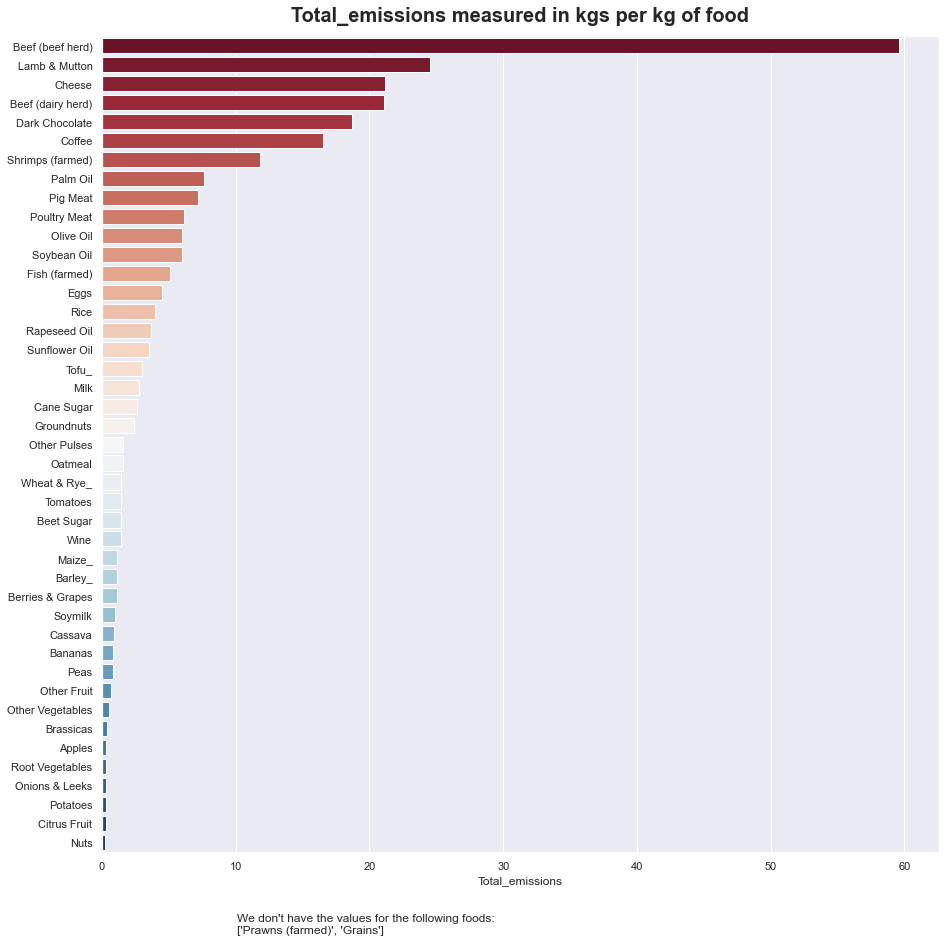

<Figure size 432x288 with 0 Axes>

In [4]:
# Let's have a look at the total emissions data for the different foods
# This way, we'll see how polluting the food production process is

vis.resources_plot("Total_emissions", resources_df)
plt.show()
plt.savefig(plots_folder + "Total_emissions.png")

As we can see, animal-based products are quite polluting to produce

In [5]:
# Let's do the same for land and water use

# In those cases, we have more than one column (per kg, per 1000 kcal, per 100g of protein). I'll focus on the cost per kg as it is the best way to compare foods with such a different compositions. To produce 100g of protein based on apples, we would need quite a lot of resources, because that's not one of the key nutrients of that food. It'd be the same as measuring the amount of resources needed to get 100g of fiber from animal sources. Like way too much 

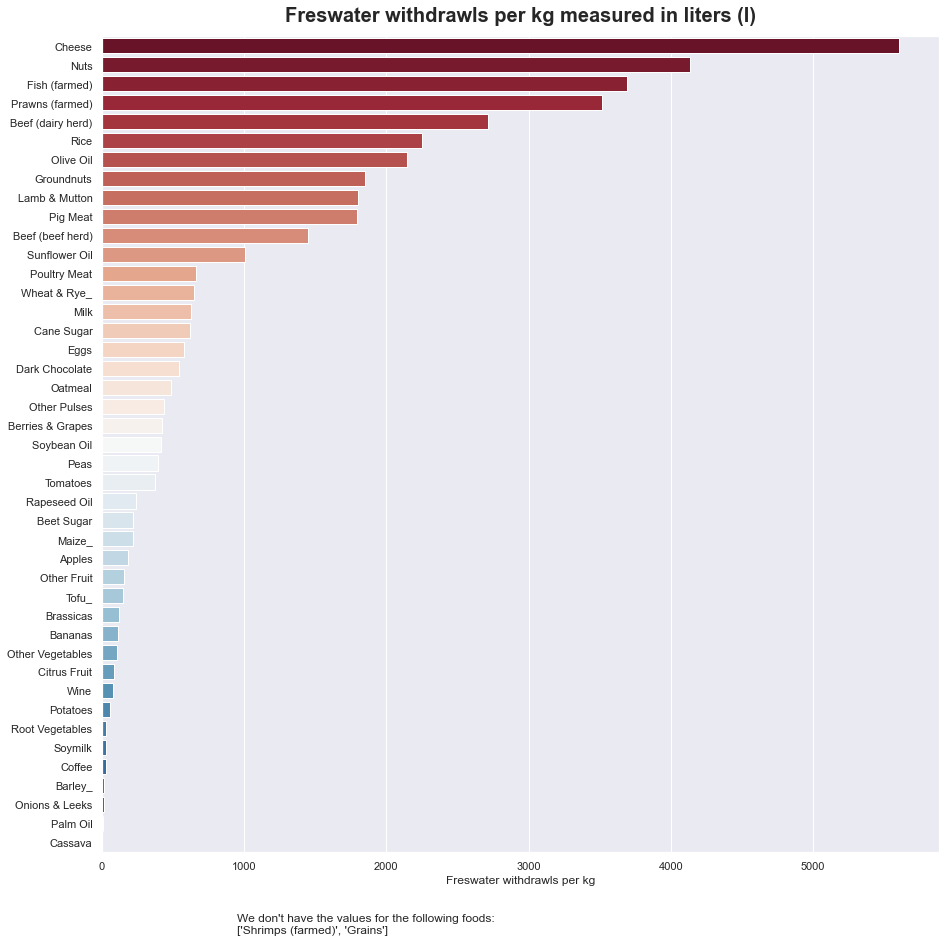

<Figure size 432x288 with 0 Axes>

In [6]:
# As mentioned, let's plot the water cost per kg of food

vis.resources_plot("Freswater withdrawls per kg", resources_df)
plt.show()
plt.savefig(plots_folder + "Freswater_withdrawls_per_kg.png")

We can see a similar trend as before: animal-based products are quite costly in terms of water.

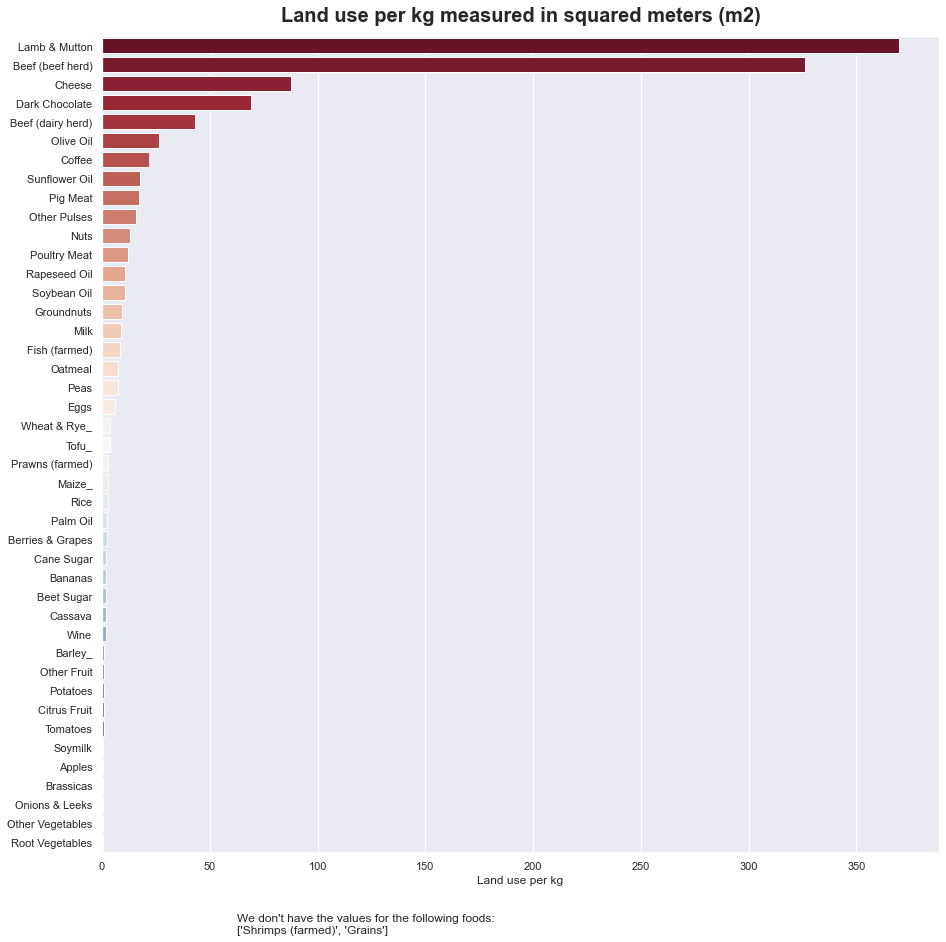

<Figure size 432x288 with 0 Axes>

In [7]:
# Last but not least, we want to see how much space is required to produce one kg of each food

vis.resources_plot("Land use per kg", resources_df)
plt.show()
plt.savefig(plots_folder + "Land_use_per_kg.png")

From this data we can already see how costly animal-based foods are from a resources standpoint compared to their plant-based counterparts.

However, to be as accurate as possible, let's see the center values comparing plant-based with animal-based

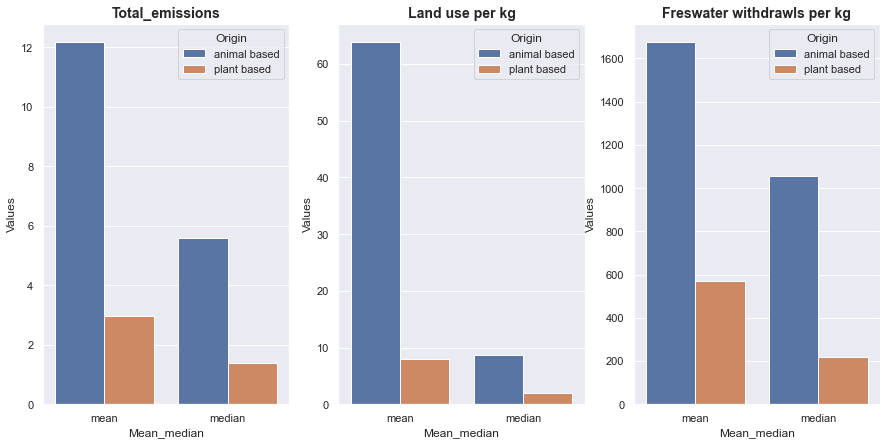

<Figure size 432x288 with 0 Axes>

In [8]:
# To have a more overall view on the problem, let's calculate the center measures (mean and median) for both animal-based and plant-based products.

# Calculate stats according to origin : mean and median
stats = md.resources_stats(resources_df, ["Total_emissions", "Land use per kg", "Freswater withdrawls per kg"])

# some required transformation before plotting
to_plot = md.stats_to_plot(stats)

# plot
vis.plot_resources_stats(to_plot)
plt.show()
plt.savefig(plots_folder + "Mean_resources_comparison.png")

We can confirm in these plots what we had already seen before: animal-based products have a huge cost in terms of resources.

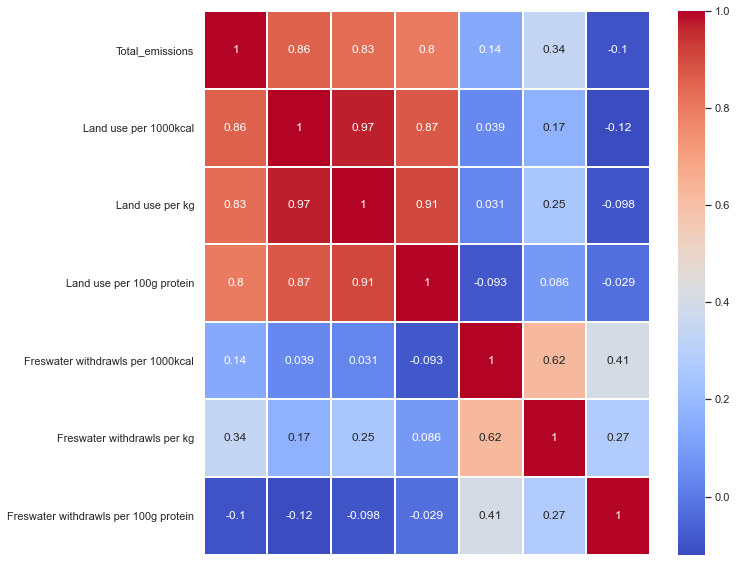

In [9]:
# The correlations here are not that interesting, but well, it doesn't hurt either
# I'm not saving this plot though
corr = resources_df.corr()
vis.correlation_plot(corr)
plt.show()

We can already conclude from this that animal-based products are much more expensive than the plant-based ones, for any category of the analysed ones.

Now, let's move on to the nutritional values analysis to see whether this "cost" difference is justified.

## Nutritional values and daily intake

In [10]:
# Let's import the nutritional values data

# path to files
path_nutrition = fo.path_to_folder(2, "data")
filename_nutrition = "2017-2018 FNDDS At A Glance - FNDDS Nutrient Values.xlsx"

# data prep
nutrition_df = md.get_nutrition_data(path_nutrition, filename_nutrition)
nutrition_df.head()

,Category number,Category name,Protein (g),Water (g),"Fiber, total dietary (g)","Vitamin A, RAE (mcg_RAE)",Thiamin (mg),Riboflavin (mg),Niacin (mg),Vitamin B-6 (mg),...,Energy (kcal),Total Fat (g),"Fatty acids, total saturated (g)","Fatty acids, total monounsaturated (g)","Fatty acids, total polyunsaturated (g)",Cholesterol (mg),Vitamin D (D2 + D3) (mcg),Carbohydrate (g),Category 2,Category 3
Food name,,,,,,,,,,,,,,,,,,,,,
"Milk, human",9602,Human milk,1.03,87.50,0.0,61,0.014,0.036,0.177,0.011,...,70,4.38,2.009,1.658,0.497,14,0.1,6.89,milks,animal
"Milk, NFS",1004,"Milk, reduced fat",3.34,89.04,0.0,59,0.057,0.137,0.110,0.060,...,51,1.99,1.164,0.426,0.065,8,1.1,4.87,milks,animal
"Milk, whole",1002,"Milk, whole",3.28,88.10,0.0,32,0.056,0.138,0.105,0.061,...,60,3.20,1.860,0.688,0.108,12,1.1,4.67,milks,animal
"Milk, low sodium, whole",1002,"Milk, whole",3.10,88.20,0.0,29,0.020,0.105,0.043,0.034,...,61,3.46,2.154,0.999,0.128,14,1.3,4.46,milks,animal
"Milk, calcium fortified, whole",1002,"Milk, whole",3.28,88.10,0.0,32,0.056,0.138,0.105,0.061,...,60,3.20,1.860,0.688,0.108,12,1.1,4.67,milks,animal


In [11]:
nutrition_df[nutrition_df["Category name"].isin(md.positive_filters(0))]

,Category number,Category name,Protein (g),Water (g),"Fiber, total dietary (g)","Vitamin A, RAE (mcg_RAE)",Thiamin (mg),Riboflavin (mg),Niacin (mg),Vitamin B-6 (mg),...,Energy (kcal),Total Fat (g),"Fatty acids, total saturated (g)","Fatty acids, total monounsaturated (g)","Fatty acids, total polyunsaturated (g)",Cholesterol (mg),Vitamin D (D2 + D3) (mcg),Carbohydrate (g),Category 2,Category 3
Food name,,,,,,,,,,,,,,,,,,,,,
"Milk, human",9602,Human milk,1.03,87.50,0.0,61,0.014,0.036,0.177,0.011,...,70,4.38,2.009,1.658,0.497,14,0.1,6.89,milks,animal
"Milk, NFS",1004,"Milk, reduced fat",3.34,89.04,0.0,59,0.057,0.137,0.110,0.060,...,51,1.99,1.164,0.426,0.065,8,1.1,4.87,milks,animal
"Milk, whole",1002,"Milk, whole",3.28,88.10,0.0,32,0.056,0.138,0.105,0.061,...,60,3.20,1.860,0.688,0.108,12,1.1,4.67,milks,animal
"Milk, low sodium, whole",1002,"Milk, whole",3.10,88.20,0.0,29,0.020,0.105,0.043,0.034,...,61,3.46,2.154,0.999,0.128,14,1.3,4.46,milks,animal
"Milk, calcium fortified, whole",1002,"Milk, whole",3.28,88.10,0.0,32,0.056,0.138,0.105,0.061,...,60,3.20,1.860,0.688,0.108,12,1.1,4.67,milks,animal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Chocolate milk, made from sugar free syrup with whole milk",1202,"Flavored milk, whole",3.23,86.94,0.4,28,0.051,0.130,0.138,0.056,...,58,3.05,1.720,0.655,0.100,10,1.0,5.87,milks,animal
"Hot chocolate / Cocoa, made with dry mix and whole milk",1202,"Flavored milk, whole",3.73,76.61,0.5,28,0.059,0.195,0.169,0.065,...,105,3.31,1.929,0.773,0.109,10,1.0,15.16,milks,animal
"Hot chocolate / Cocoa, made with no sugar added dry mix and whole milk",1202,"Flavored milk, whole",4.26,81.29,0.6,30,0.070,0.239,0.184,0.079,...,85,3.18,1.853,0.711,0.106,11,1.0,10.08,milks,animal


In [12]:
# Now that we are all set, let's do some quick calculation of the mean grouped by food categories, to see the average nutrients those groups have

stats = md.nutrients_stats(nutrition_df)
stats.T

Category 2,_others,beans,cheese,chicken,fish,meats,milk_substitutes,milks,nuts,other_animal_products,other_veggie_products,soy_products
Protein (g),6.106124,8.882973,20.260959,23.178750,21.006613,22.729176,1.506667,4.899863,17.534103,10.936909,6.276111,15.675714
Water (g),59.877912,60.673784,51.280959,60.545580,63.887604,55.945056,85.346296,83.182055,4.731667,67.593091,58.740278,54.651429
"Fiber, total dietary (g)",1.864018,7.198649,0.100000,0.159375,0.287558,0.131461,0.429630,0.141096,8.097436,0.117576,2.558333,3.985714
"Vitamin A, RAE (mcg_RAE)",73.561256,2.459459,167.876712,15.071429,49.997696,112.614232,62.851852,45.917808,16.320513,174.266667,71.875000,5.190476
Thiamin (mg),0.174190,0.147946,0.038397,0.089013,0.123889,0.322446,0.022074,0.047192,0.291718,0.047521,0.192750,0.986667
Riboflavin (mg),0.178326,0.072365,0.326178,0.203741,0.150747,0.329760,0.104370,0.184644,0.296808,0.358691,0.130958,0.317095
Niacin (mg),2.321376,0.620784,0.257000,6.596643,4.530237,5.590228,0.346074,0.174603,5.365897,0.367958,2.924569,4.460524
Vitamin B-6 (mg),0.178717,0.158378,0.091808,0.402201,0.286878,0.338187,0.030222,0.055890,0.375179,0.156812,0.152431,0.400905
Vitamin B-12 (mcg),0.441916,0.019730,1.082877,0.473080,3.589263,2.267566,0.408889,0.479452,0.001667,0.633273,0.067222,1.234762
"Folate, total (mcg)",43.820807,98.540541,15.246575,10.468750,18.352535,16.614232,5.703704,6.753425,81.217949,28.903030,36.069444,68.047619


Well, here we can see some information, but it is difficult to determine anything

Let's visualize for instance, milks vs substitutes and see what nutrients they both have. For that purpose, I'll bring the recommended daily intake of nutrients data. This way we can compare, how much these foods fullfill the nutrient requirements

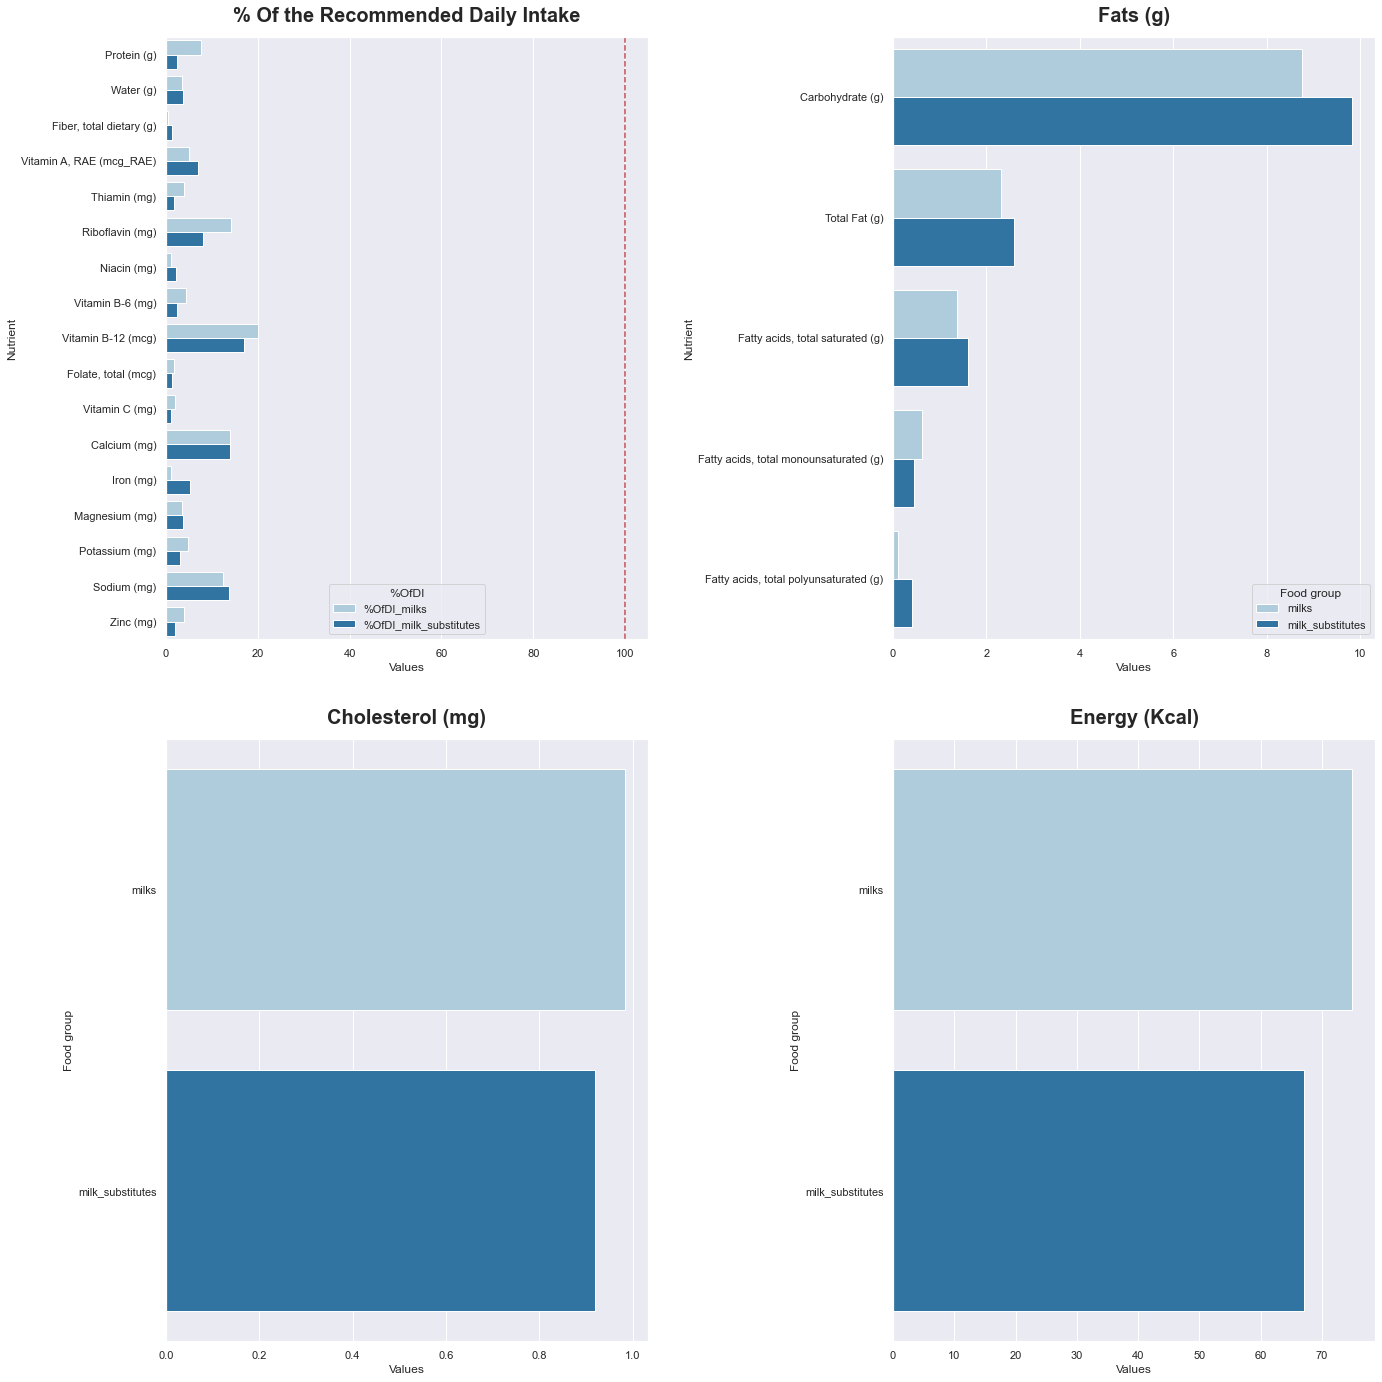

<Figure size 432x288 with 0 Axes>

In [13]:
# In order to know evaluate the quality of the food, we need some kind of measure first
# With that purpose in mind, we will use the recommended daily intakes

# We need to calculate the daily intakes
path_di = fo.path_to_folder(2, "data")
filename_di = "daily_intakes.csv"
daily_intake_df = pd.read_csv(path_di + filename_di)

# We will use a 30 years old male for these analysis
male_30 = md.get_daily_intake_data("male", 30, daily_intake_df)

# Then we choose the foods (categories in this case) we want to pass in the plotter
food_groups = ["milks", "milk_substitutes"]

# We calculate the comparison
comparison1 = md.full_comparison(male_30, stats, food_groups)

# We plot this
vis.full_comparison_plot(comparison1)

plt.show()
plt.savefig(plots_folder + "milks_vs_milk_substitutes.png")

Quick comment on the plot:
- left-up : we see what percentage of the daily intake these foods are filling with 100g. This means, if Iron is 20% for a given food, that means, 100g of that specific food are getting us 20% of our iron need. Unit : %

- right-up : here we can see how many grams of carbohydrate and the different fats both nutrients have. Notice that "total fat" equals the sum of the rest of the fats.  Unit : g

- left-down : here we can see a cholesterol comparison. Unit : mg

- right-down : the energy value. Unit : kcal

Well, here we can see that the traditional milk is over the veggie substitutes when talking about: protein, vitamin B12, Sodium, Zinc, etc... 

On the other hand, we can also see that the traditional milk is more fat-loaded and they have higher calories.

However, as the range of products included in both milk_substitutes and milks varies a lot (for instance, milks includes yogurts and milk_substitutes includes several kinds of milk, like soy, almond, coconut, etc..), let's compare soy milk with any standard milk, to see what that looks like.

In [14]:
nutrition_df[nutrition_df["Category 2"] == "milks"].index[:15]

Index(['Milk, human', 'Milk, NFS', 'Milk, whole', 'Milk, low sodium, whole',
       'Milk, calcium fortified, whole',
       'Milk, calcium fortified, low fat (1%)',
       'Milk, calcium fortified, fat free (skim)', 'Milk, reduced fat (2%)',
       'Milk, acidophilus, low fat (1%)',
       'Milk, acidophilus, reduced fat (2%)', 'Milk, low fat (1%)',
       'Milk, fat free (skim)', 'Milk, lactose free, low fat (1%)',
       'Milk, lactose free, fat free (skim)',
       'Milk, lactose free, reduced fat (2%)'],
      dtype='object', name='Food name')

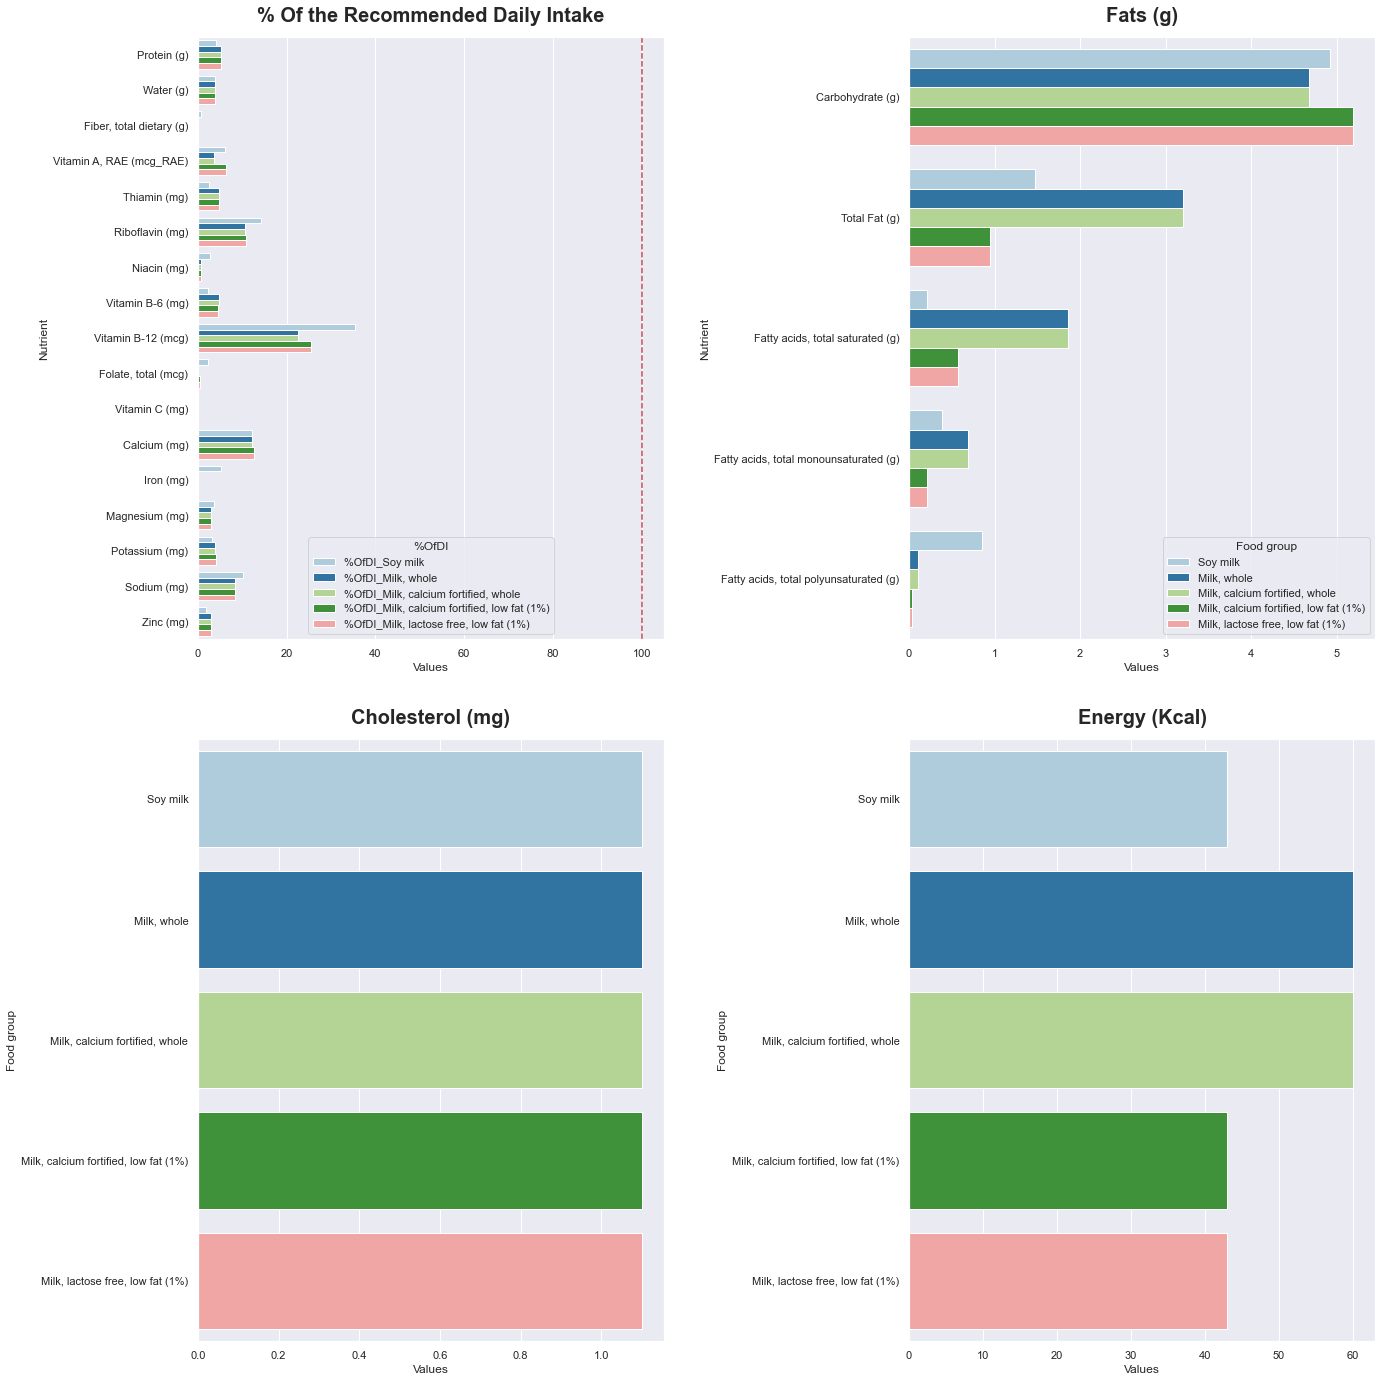

<Figure size 432x288 with 0 Axes>

In [15]:
# We just need the new items to compare, and the nutrition_df 
foods = ["Soy milk", "Milk, whole", "Milk, calcium fortified, whole",
        "Milk, calcium fortified, low fat (1%)", "Milk, lactose free, low fat (1%)"]

# We calculate the comparison
comparison2 = md.full_comparison(male_30, nutrition_df, foods)

# We plot this
vis.full_comparison_plot(comparison2)
plt.show()
plt.savefig(plots_folder + "soy_milk_vs_other_milks.png")

Now we can see better how soy milk not only is as nutritional as other milks, but it even outperform most of milks in several categories, such as: Vitamin-A, Riboflavin, Vitamin-B12. And on top of all this, at a lower saturated-fat cost (I focus on this one because it's the one that should be avoided).

Now let's do this with the different types of meat and their veggie counterparts.

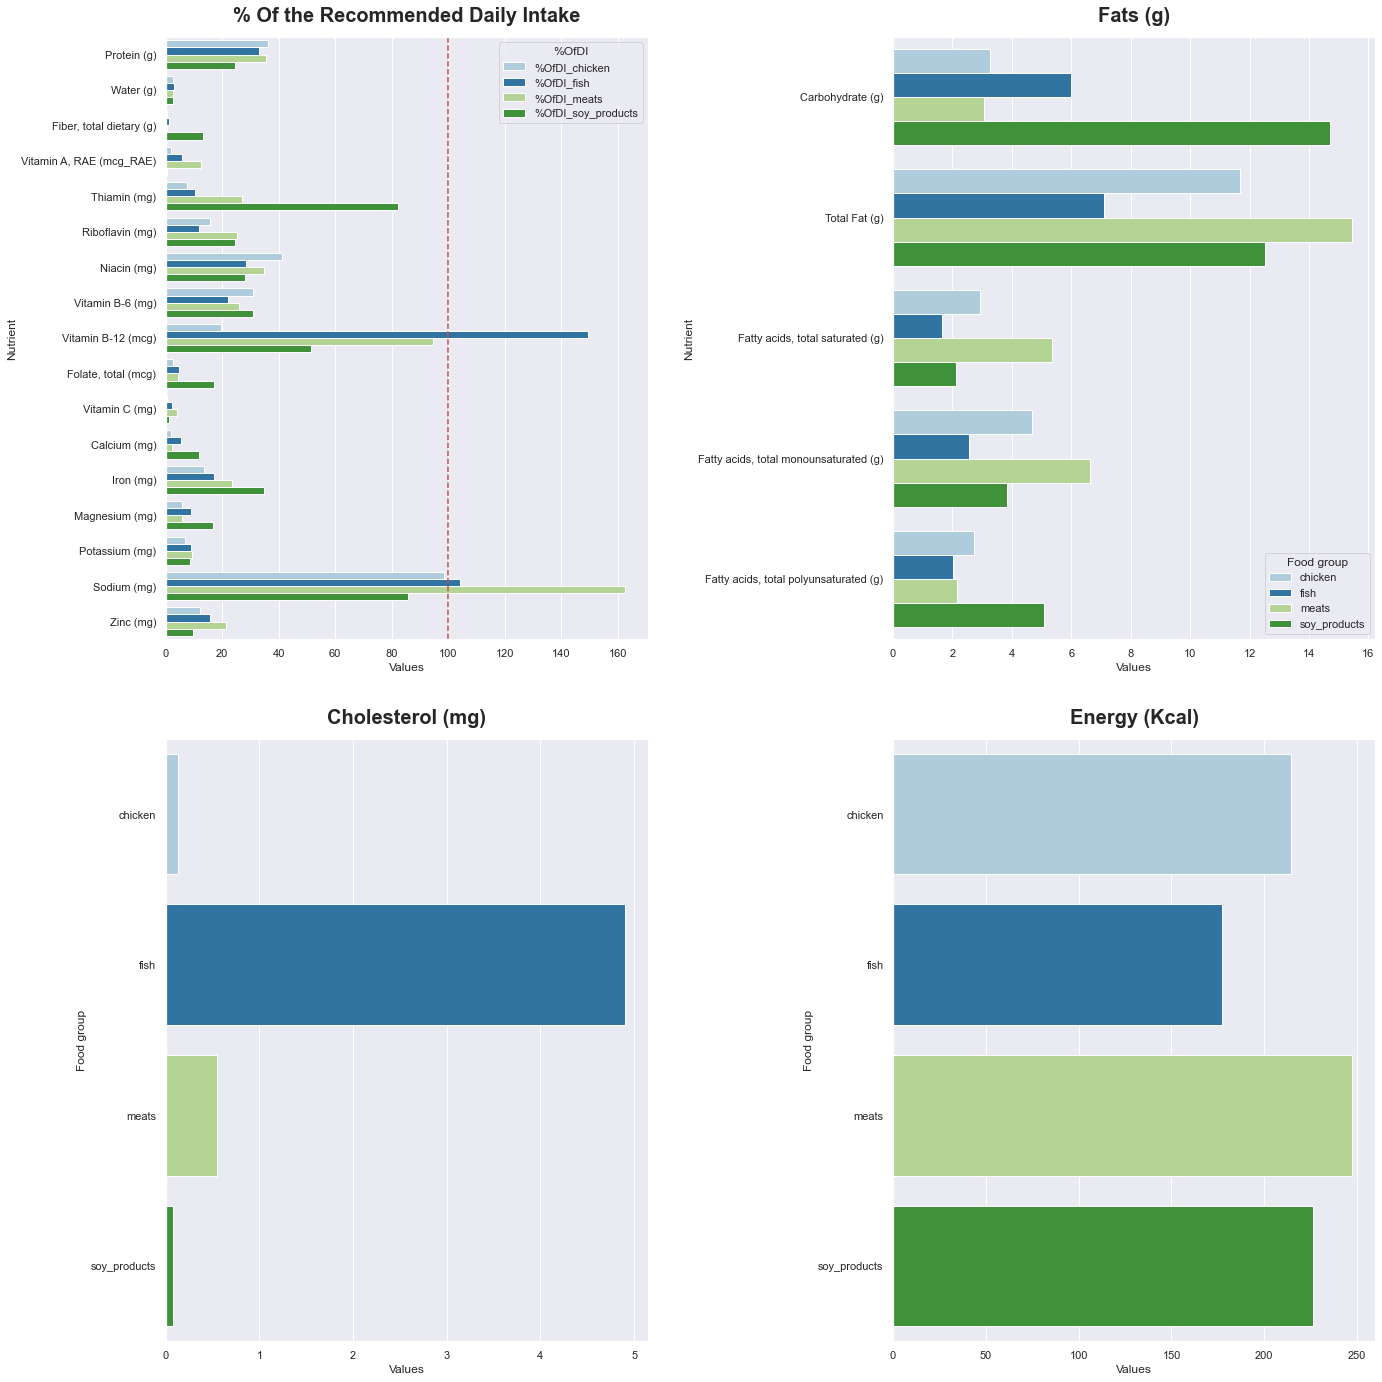

<Figure size 432x288 with 0 Axes>

In [16]:
# Let's compare for instance, chicken, fish and meats vs soy_products

# We just need the new items to compare, and the nutrition_df 
foods_2 = ["chicken", "fish", "meats", "soy_products"]

# We calculate the comparison
comparison3 = md.full_comparison(male_30, stats, foods_2)

# We plot this
vis.full_comparison_plot(comparison3)
plt.show()
plt.savefig(plots_folder + "soy_products_vs_animal_products.png")

Now, several things we can comment on:

1 - Soy products have (in general) less protein than those coming from animal sources. However, we can see that the difference is no bigger than 10-15% in terms of filling the recommended daily intake. If we go back in the file, we will see that the cost of producing meat compared to tofu for instance, is way higher. So, it is clearly not an efficient option. We'll go deeper in to that.

2 - Soy products have half of the Vitamin B12, but 100g still help us reach above 50% of the necessary.

3 - Soy products are rich fiber, whereas no animal-product have any fiber.

4 - As before with the milk, we can see that the fat distribution for soy products goes mainly to unsaturated fats, performing better than almost anything but fish.

5 - Cholesterol based, it's definitely the best option.

# Conclusions

We could go on with the comparisons, for instance with beans, as they are a very interesting option from a nutritional standpoint. However, we'll leave it here.

To conclude: we could see that animal-based options definitely have some advantages. This is undeniable. However, from a efficiency perspective, we (as socieaty) pay a too high price for these products, when we could find the missing nutrients in other cheaper (and also nutritious) options.

Answer to the questions:

a. Was it possible to demonstrate the hypothesis? Why?
We can see how expensive the animal-based food is and even with the advantages that thay may offer, from a nutritional perspective there are already plant-based food that can replace them at a much lower cost.

b. What can you conclude about your data study?
Same stated above.

c. What would you change if you need to do another EDA project?
I'd start setting clear prioritiries and deadlines. I was way too caotic doing this one.

d. What do you learn doing this project?
Focus and a proper work organization is key.

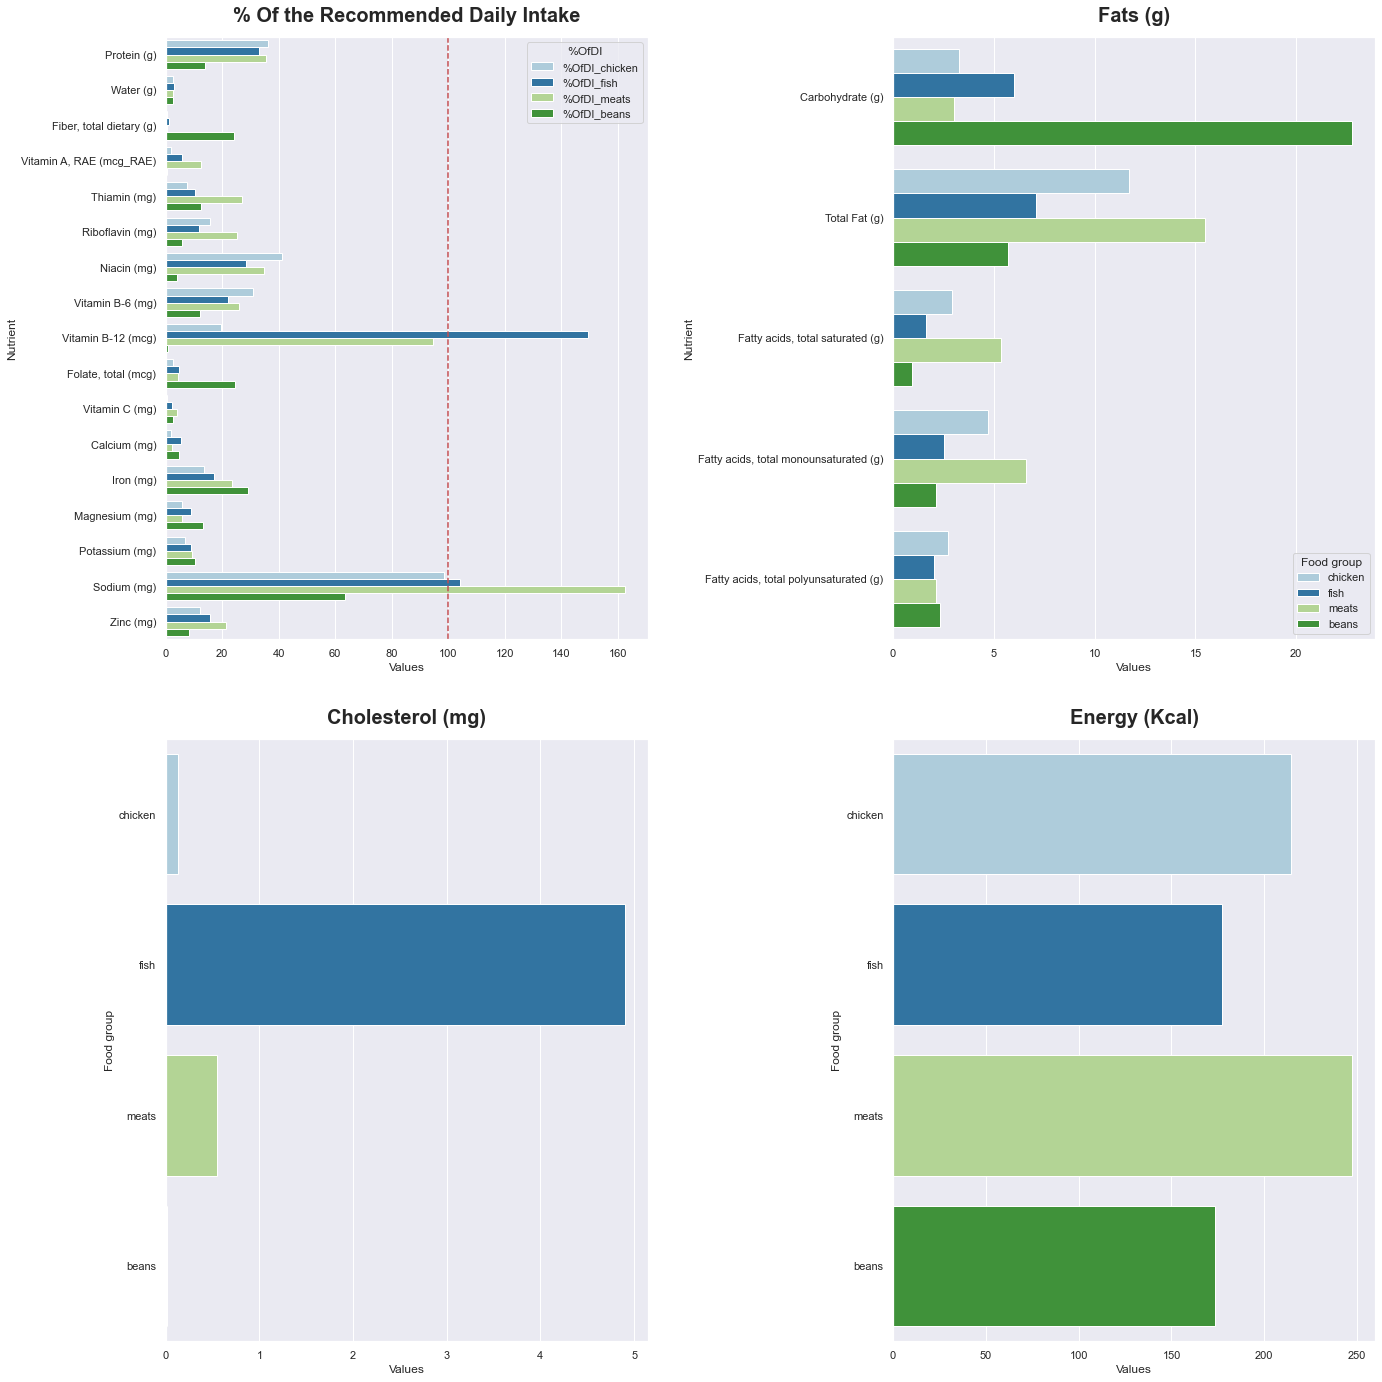

In [17]:
# Just for the fun of it
# Let's compare for instance, chicken, fish and meats vs beans

# We just need the new items to compare, and the nutrition_df 
foods_3 = ["chicken", "fish", "meats", "beans"]

# We calculate the comparison
comparison4 = md.full_comparison(male_30, stats, foods_3)

# We plot this
vis.full_comparison_plot(comparison4)
plt.show()